# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
counter = 0
for c in combined.columns:
    if counter % 10 == 0:
        print("\n")
        counter = 0
    print(c, end=", ")
    counter += 1
    



DBN, SCHOOL NAME, Num of SAT Test Takers, SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, sat_score, SchoolName, AP Test Takers , Total Exams Taken, 

Number of Exams with scores 3 4 or 5, Demographic, School Name, Cohort, Total Cohort, Total Grads - n, Total Grads - % of cohort, Total Regents - n, Total Regents - % of cohort, Total Regents - % of grads, 

Advanced Regents - n, Advanced Regents - % of cohort, Advanced Regents - % of grads, Regents w/o Advanced - n, Regents w/o Advanced - % of cohort, Regents w/o Advanced - % of grads, Local - n, Local - % of cohort, Local - % of grads, Still Enrolled - n, 

Still Enrolled - % of cohort, Dropped Out - n, Dropped Out - % of cohort, CSD, NUMBER OF STUDENTS / SEATS FILLED, NUMBER OF SECTIONS, AVERAGE CLASS SIZE, SIZE OF SMALLEST CLASS, SIZE OF LARGEST CLASS, SCHOOLWIDE PUPIL-TEACHER RATIO, 

Name, schoolyear, fl_percent, frl_percent, total_enrollment, prek, k, grade1, grade2, grade3, 

grade4, grade5, grade6

In [12]:
print(combined.loc[:10,["rr_s", "rr_p", "rr_t"]])

    rr_s  rr_p  rr_t
0   89.0    39    70
1   84.0    10    95
2    0.0    28    98
3   90.0    21   100
4   98.0    51    68
5   98.0    50    81
6   72.0    30    76
7   86.0    57   100
8   48.0     9    56
9   61.0    56    96
10  96.0    46   100


## SAT Scores correlations plot


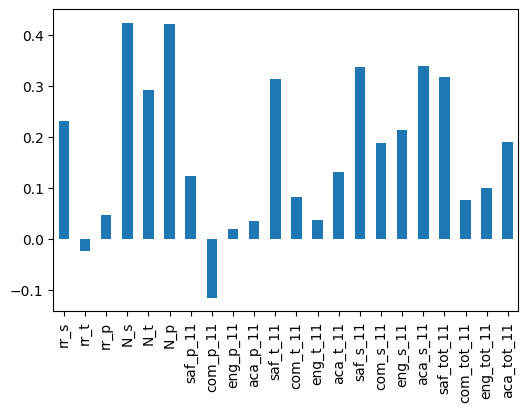

In [13]:
correlations[survey_fields].plot(kind="bar")
plt.show()

The data confirms most of the expected coorelations as student safety and communication positively coorelates with sat score. 
More interestingly while student perceived academic standards coorelates strongly with sat score, the same is not true with teachers' perceived standards. The parents' perceived standards coorelates even worse. This shows that adults have lower faith on the education system than the children.

## Plot of safety score given by students against SAT scores.

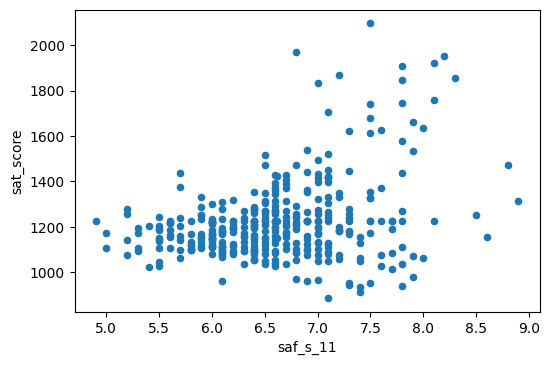

In [14]:
combined.plot.scatter(x="saf_s_11", y="sat_score")
plt.show()

There's no clear relationship between "Safety & Respect" scores given by students and the SAT scores. It may have resulted in strong positive relationship because a lot of middle values are consistent.

In [15]:
import numpy as np
Average_safety_score_by_borough = combined.groupby('boro').agg(np.mean)[['saf_p_11'
,'saf_t_11','saf_s_11']]


In [16]:
Average_safety_score_by_borough

,saf_p_11,saf_t_11,saf_s_11
boro,,,
Bronx,8.346237,7.026882,6.606577
Brooklyn,8.036792,6.985849,6.370755
Manhattan,8.288889,7.287778,6.831370
Queens,8.098437,7.365625,6.721875
Staten Island,7.800000,7.210000,6.530000


The average safety score is highest by parents followed by teachers and student across all 5 boroughs of New York.

## Relationship between different races and SAT scores

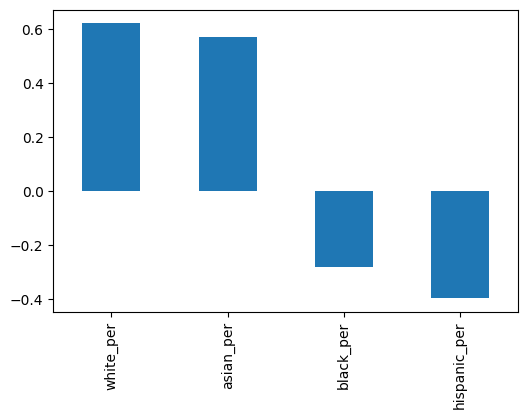

In [17]:
correlations[['white_per','asian_per','black_per','hispanic_per']].plot.bar()
plt.show()

SAT Score has strong positive relationship in schools where percentage of white/asian is high.
On the other hand, SAT score has a negative correlation with schools with high black/hispanic people.

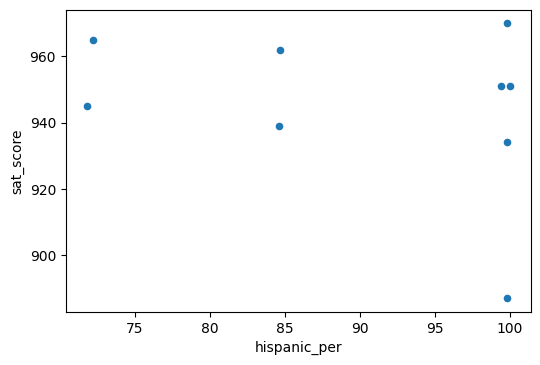

In [18]:
low_score_high_hispanic_bool = (combined['hispanic_per'] > 50) & (combined['sat_score'] < 1000)
low_score_high_hispanic = combined[low_score_high_hispanic_bool]
low_score_high_hispanic.plot.scatter(x="hispanic_per", y="sat_score")
plt.show()

The plot shows no relationship between high hispanic people and low sat scores. However, there are a couple of schools with relatively high hispanic percentage scoring very poor in SAT's.

In [20]:
more_than_95per_hispanic = combined[combined["hispanic_per"] > 95]
schools_with_more_than_95per_hispanic = more_than_95per_hispanic["SCHOOL NAME"]
schools_with_more_than_95per_hispanic

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Schools with high hispanic percentage(> 95%) often have graduation rate below 60%

In [21]:
low_hispanic_high_sat_score_bool = (combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)
low_hispanic_high_sat_score = combined[low_hispanic_high_sat_score_bool]
low_hispanic_high_sat_score_schools = low_hispanic_high_sat_score["SCHOOL NAME"]
low_hispanic_high_sat_score_schools

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools are mostly dominated by Asians.

## Gender Correlation with SAT scores

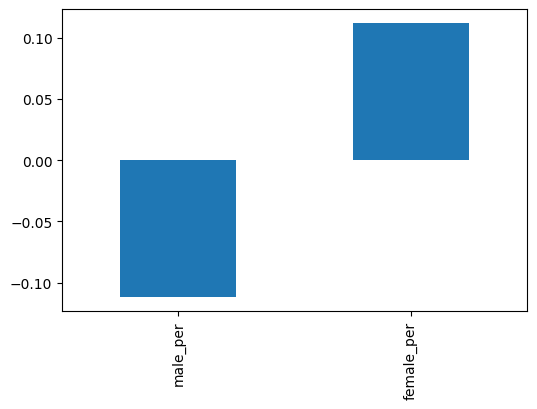

In [22]:
correlations[["male_per","female_per"]].plot.bar()
plt.show()

The analysis shows that high percentage of male correlates negatively with SAT's but high percentage of female correlates positively; hoever, neither are strong.

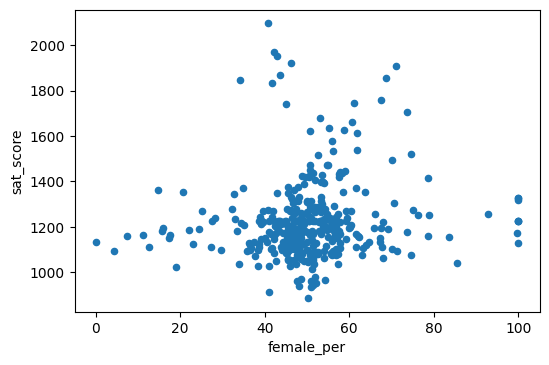

In [24]:
combined.plot.scatter(x="female_per", y="sat_score")

There doesn't seems to be any relationship.

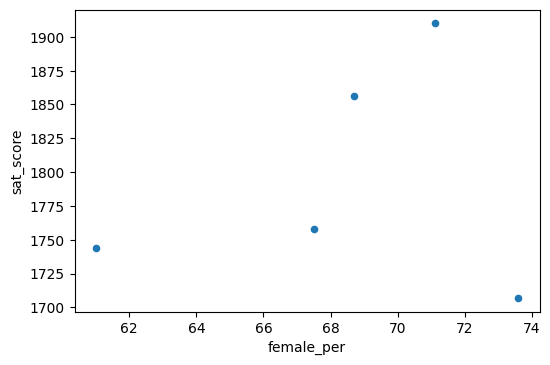

In [23]:
high_female_high_sat = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]
high_female_high_sat.plot.scatter(x="female_per", y="sat_score")
plt.show()

It indicates a positive relationship where generally as the female percentage increase the sat score also increases.

In [25]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


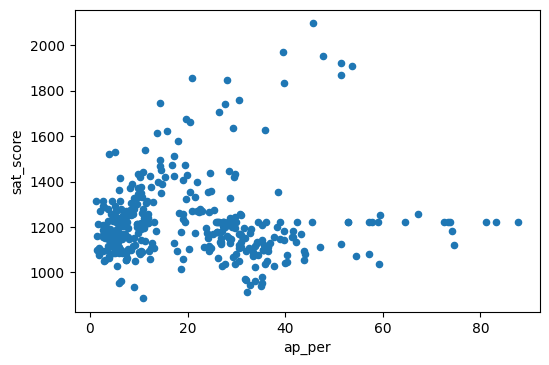

In [27]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]*100
combined.plot.scatter(x="ap_per", y="sat_score")

There doesn't seem to be any coorelationship between the two; however, a lot of of schools with lower percentage of AP test takers also scored poorly.